In [4]:
import sys
import numpy as np
from tqdm import tqdm
#!{sys.executable} -m pip install nilearn #install relevant package
from preprocessing import load_and_mask_miyawaki_data, plt_background

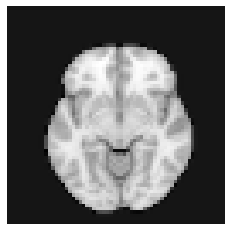

In [5]:
#Plot the pretty brain we are working on
plt_background()

In [6]:
fmri_data, stimuli, masker = load_and_mask_miyawaki_data()

Preprocessing data...

Preprocessed fMRI data: 2860 samples x 5438 voxels
Preprocessed stimuli data: 2860 samples x 100 pixels


 Done (18.67s).


## First step: Decoding


Let's infer the binary visual stimulus presented to the subject from the recorded fMRI data.

Simple classification: X = fMRI data, y = binary stimuli

As done in Abraham et al., we first use a l1 logistic regression

Issue: the article is from 2014, so some of the code is deprecated: need to correct it

In [15]:
"""from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

pipeline_LR = Pipeline(steps=[('selection', SelectKBest(f_classif, k=500)),('clf', LR(penalty='l1', C=0.05))])

scores_lr = []
# y_train = n_samples x n_voxels
# To iterate on voxels, we transpose it. 
for pixel in tqdm(y_train.T):
    score = cross_val_score(pipeline_LR, X_train, pixel, cv=5)
    scores_lr.append(score)"""

In [19]:
from sklearn.model_selection import train_test_split

train_to_test_ratio = 0.8
X_train, X_test, Y_train, Y_test =train_test_split(fmri_data, stimuli, 
                                        train_size=train_to_test_ratio, 
                                        test_size=1.0-train_to_test_ratio)

In [ ]:
X_train

In [14]:
from sklearn import linear_model

C_list = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]



scores_lr = []
# loop over regularisation strength
for pixel in tqdm(100):
    
    # define logistic regressor
    logreg=linear_model.LogisticRegression(penalty='l2', C=0.05)
    
    # fit training data
    logreg.fit(X_train, Y_train)
    
    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    
    print('accuracy: train, test')
    print('liblin: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i]) )

0it [00:00, ?it/s]


TypeError: 'int' object is not iterable

## Second step: Encoding

In [18]:
from sklearn.linear_model import Ridge 
from sklearn.model_selection import KFold

cv = KFold(n_splits=10)

# Fit ridge model, calculate predictions on left out data
# and evaluate r^2 score for each voxel
scores = []
for train, test in tqdm(cv.split(y_train)):
    pred = (Ridge(alpha=100.).fit(y_train[train], X_train[train]).predict(y_train[test]))
    X_true = X_train[test]
    scores.append(1. - ((X_true - pred)** 2).sum(axis=0) /((X_true - X_true.mean(axis=0))** 2).sum(axis=0))
mean_scores = np.mean(scores, axis=0)


10it [00:01,  7.06it/s]


In [19]:
from sklearn.linear_model import LassoLarsCV
# choose number of voxels to treat, set to None for all voxels
n_voxels = 50
# choose best voxels
indices = mean_scores.argsort()[::-1][:n_voxels]
lasso = LassoLarsCV(max_iter=10)
receptive_fields = [] 
for index in indices:
    lasso.fit(y_train, X_train[:, index])
    receptive_fields.append(lasso.coef_.
        reshape(10, 10))